In [ ]:
%pip install pandas matplotlib seaborn plotly scikit-learn seaborn missingno

In [ ]:
!python -m pip install xgboost

In [ ]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML
import missingno as mn
import seaborn as sns
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

sns.set()
RANDOM_SEED = 42

In [64]:
#Интерактивные графики в отдельном окне
%matplotlib tk

In [65]:
%matplotlib inline

# Загрузка данных

### Сразу удалим дубликаты и проверим типы данных

In [108]:
df = pd.read_csv("autos.csv")
if df.duplicated().sum():
    df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(9)
me

## Преобразование данных

#### Видим множество признаков, с типами object. Даты преобразуем в datetime64. А прочие в категории.

In [109]:
df["DateCrawled"] = pd.to_datetime(df.DateCrawled)
df["DateCreated"] = pd.to_datetime(df.DateCreated)
df["LastSeen"] = pd.to_datetime(df.LastSeen)

categorical_cols = ["VehicleType", "Gearbox", "FuelType", "Brand", "Model", "Repaired"]
for category in categorical_cols:
    df[category] = df[category].astype("category")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  category      
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  category      
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  category      
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  category      
 10  Brand              354365 non-null  category      
 11  Repaired           283211 non-null  category      
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64        

In [110]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354365,2016-03-21 12:58:09.520460544,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354365.0,4416.67983,0.0,1050.0,2700.0,6400.0,20000.0,4514.176349
RegistrationYear,354365.0,2004.234481,1000.0,1999.0,2003.0,2008.0,9999.0,90.228466
Power,354365.0,110.093816,0.0,69.0,105.0,143.0,20000.0,189.85133
Kilometer,354365.0,128211.363989,5000.0,125000.0,150000.0,150000.0,150000.0,37905.083858
RegistrationMonth,354365.0,5.71465,0.0,3.0,6.0,9.0,12.0,3.726432
DateCreated,354365,2016-03-20 19:12:06.583042560,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354365.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.5038,1067.0,30165.0,49413.0,71083.0,99998.0,25783.100078
LastSeen,354365,2016-03-29 23:51:06.766184960,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:52,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


#### Видим, что есть 
* нулевая Price
* нереальный RegistrationYear
* огромная Power

## Фильтрация данных

### Фильтрация неверной мощности

<Axes: xlabel='Power', ylabel='Count'>

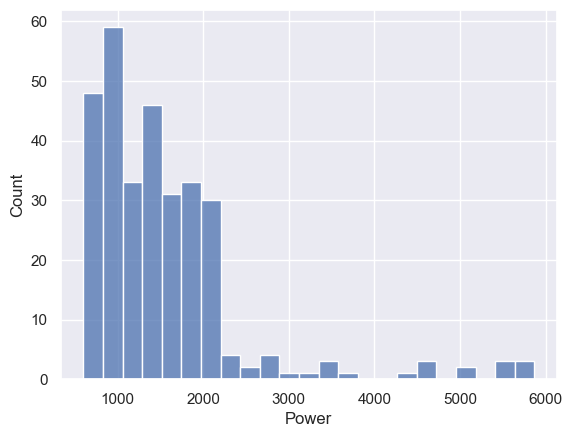

In [111]:
sns.histplot(df.Power.loc[(df.Power > 600) & (df.Power < 6000)])

Возможно пользователь ошибся и добавил лишние нули. Попробуем восстановить мощность по модели

Найдем среднее значение мощности для выбранных моделей

In [112]:
huge_power_models = df.loc[df.Power > 600].Model.unique().tolist()
median_power = {}
for model in huge_power_models:
    median = df["Power"].loc[df.Model == model].median()
    try:
        median_power[model] = round(median)
    except ValueError:
        print(model, "can't convert to int", median)


nan can't convert to int nan


Проверим реальность данных

In [113]:
sorted([i for i in median_power.items()], key=lambda i: i[1])

[('kaefer', 34),
 ('lupo', 50),
 ('arosa', 50),
 ('matiz', 52),
 ('seicento', 54),
 ('twingo', 58),
 ('punto', 60),
 ('corsa', 60),
 ('ypsilon', 60),
 ('ka', 60),
 ('micra', 60),
 ('fortwo', 60),
 ('polo', 60),
 ('agila', 60),
 ('up', 60),
 ('fiesta', 65),
 ('aygo', 68),
 ('spark', 68),
 ('c2', 68),
 ('500', 69),
 ('colt', 75),
 ('ibiza', 75),
 ('fabia', 75),
 ('cordoba', 75),
 ('kangoo', 75),
 ('forfour', 75),
 ('clio', 75),
 ('yaris', 75),
 ('sandero', 75),
 ('doblo', 84),
 ('2_reihe', 88),
 ('escort', 90),
 ('caddy', 90),
 ('berlingo', 90),
 ('rio', 90),
 ('80', 90),
 ('civic', 90),
 ('golf', 95),
 ('a_klasse', 95),
 ('corolla', 97),
 ('astra', 101),
 ('focus', 101),
 ('transporter', 102),
 ('stilo', 103),
 ('bravo', 103),
 ('3_reihe', 105),
 ('toledo', 105),
 ('scenic', 107),
 ('megane', 107),
 ('other', 109),
 ('c4', 109),
 ('sprinter', 109),
 ('nubira', 112),
 ('vectra', 116),
 ('v40', 116),
 ('galaxy', 116),
 ('ceed', 116),
 ('octavia', 116),
 ('sharan', 116),
 ('c_max', 116),
 

#### Восстановим мощности из среднего

In [114]:
# Восстановим мощности
df["Power"].update(df.loc[df.Power > 600]["Model"].map(median_power))

In [115]:
df.loc[df.Power > 600]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,NaN,150000,0,petrol,honda,NaN,2016-04-02,0,21509,2016-04-04 09:15:26
21609,2016-03-29 17:53:17,200,small,2000,manual,1200,NaN,125000,4,petrol,lancia,NaN,2016-03-29,0,10585,2016-04-06 03:45:24
24591,2016-03-25 14:55:04,1499,sedan,1998,manual,1011,NaN,100000,12,petrol,opel,NaN,2016-03-25,0,47475,2016-04-06 18:18:38
34332,2016-04-01 06:02:10,450,NaN,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01,0,63322,2016-04-01 09:42:30
46073,2016-04-05 10:51:31,0,sedan,2002,manual,1102,NaN,150000,7,gasoline,seat,no,2016-04-05,0,27432,2016-04-05 11:42:08
46941,2016-04-06 15:25:37,15000,coupe,2013,auto,751,NaN,10000,1,petrol,sonstige_autos,no,2016-04-06,0,60386,2016-04-06 15:25:37
50191,2016-03-11 15:39:20,650,small,2003,auto,602,NaN,90000,10,NaN,lancia,yes,2016-03-11,0,67705,2016-03-16 01:45:31
56059,2016-03-16 21:49:40,2450,bus,1992,manual,2017,NaN,150000,6,NaN,volkswagen,NaN,2016-03-16,0,24340,2016-03-30 18:46:06
59887,2016-03-30 20:53:15,300,sedan,2004,manual,1002,NaN,150000,4,NaN,ford,yes,2016-03-30,0,61440,2016-03-30 21:45:13


Для этих авто не указаны ни корректная мощность, ни модель. Удаляем их

In [116]:
df.drop(df[df.Power > 600].index, inplace=True)

#### Отфильтруем RegistrationDate удалив года, которые старше самой выборки или были выпущены раньше 1900г

In [117]:
df.RegistrationYear.loc[df.RegistrationYear > 2019].describe().T # Перебором года удалось выяснить граничный реальный год

count     105.000000
mean     6399.276190
std      2750.727549
min      2066.000000
25%      4100.000000
50%      5911.000000
75%      9996.000000
max      9999.000000
Name: RegistrationYear, dtype: float64

In [118]:
df.RegistrationYear.loc[df.RegistrationYear < 1900].describe().T

count      63.000000
mean     1165.190476
std       246.692760
min      1000.000000
25%      1000.000000
50%      1000.000000
75%      1254.000000
max      1800.000000
Name: RegistrationYear, dtype: float64

<Axes: >

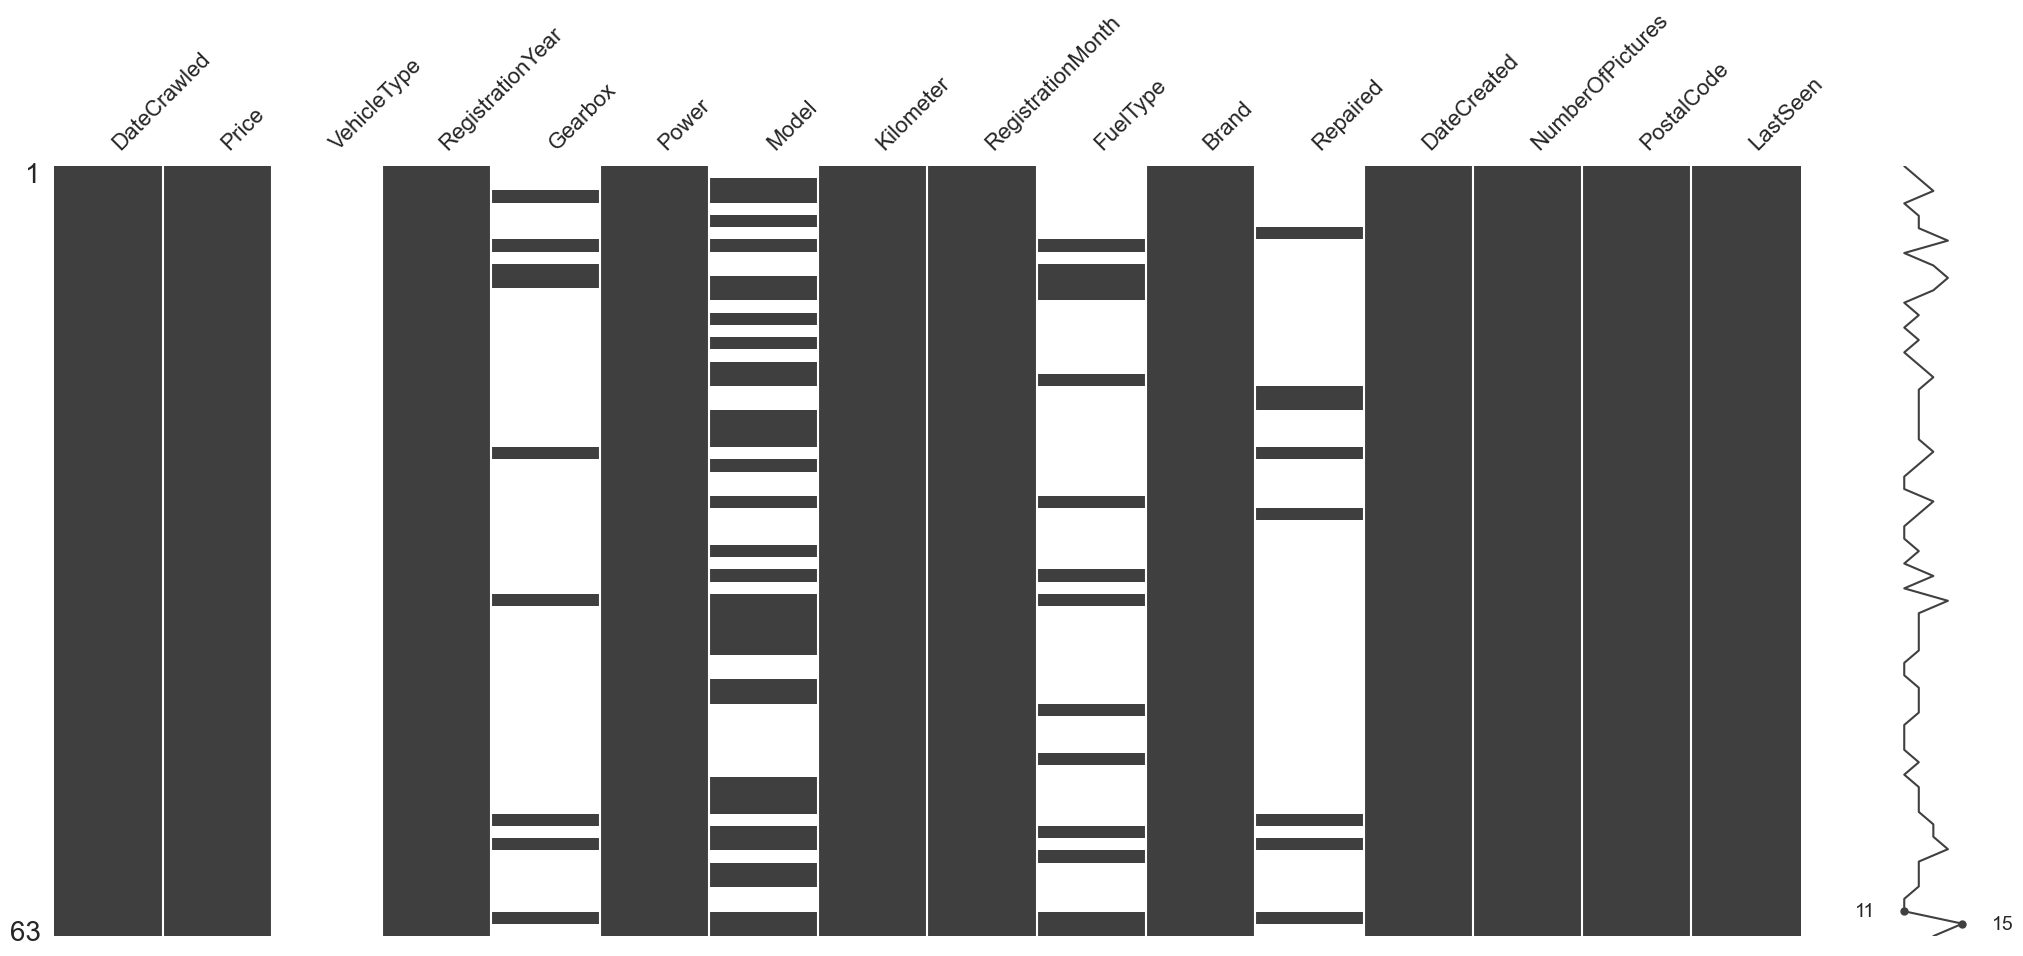

In [119]:
mn.missingno.matrix(df.loc[df.RegistrationYear < 1900])

<Axes: >

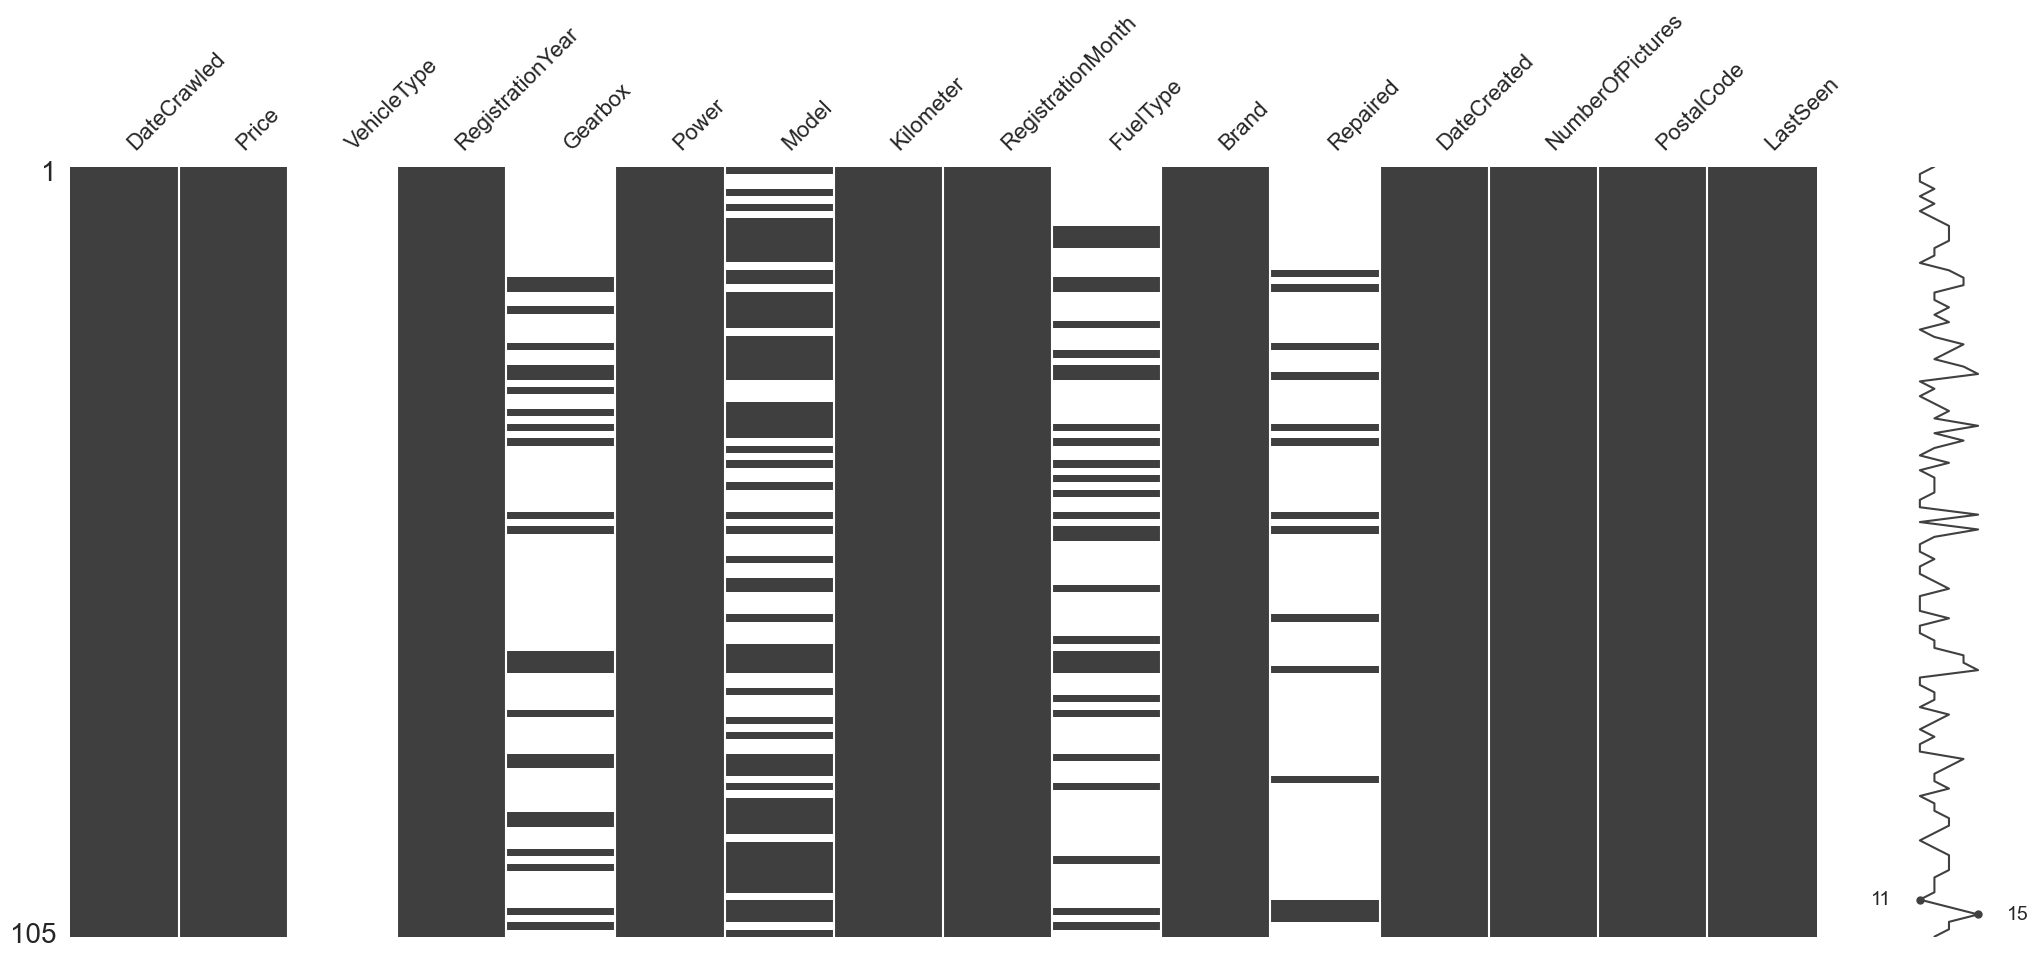

In [120]:
mn.missingno.matrix(df.loc[df.RegistrationYear > 2019])

Как видно, пользователи не удосужился заполнить объявление. Т.к. таких объявлений не много, то удаляем их

In [121]:
df = (df.drop(df.loc[df.RegistrationYear > 2019].index).
         drop(df.loc[df.RegistrationYear < 1900].index))
df.describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354147,2016-03-21 12:57:46.524208896,2016-03-05 14:06:22,2016-03-13 11:52:24.500000,2016-03-21 17:50:53,2016-03-29 14:37:18.500000,2016-04-07 14:36:58,NaN
Price,354147.0,4417.868504,0.0,1050.0,2700.0,6400.0,20000.0,4514.181466
RegistrationYear,354147.0,2003.085123,1910.0,1999.0,2003.0,2008.0,2019.0,7.535836
Power,354147.0,106.511276,0.0,69.0,105.0,141.0,600.0,63.415001
Kilometer,354147.0,128269.009761,5000.0,125000.0,150000.0,150000.0,150000.0,37821.508267
RegistrationMonth,354147.0,5.716858,0.0,3.0,6.0,9.0,12.0,3.72548
DateCreated,354147,2016-03-20 19:11:42.044065792,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354147.0,50510.89427,1067.0,30165.0,49413.0,71083.0,99998.0,25783.348351
LastSeen,354147,2016-03-29 23:51:07.381880832,2016-03-05 14:15:08,2016-03-23 02:50:06.500000,2016-04-03 15:15:51,2016-04-06 10:15:20,2016-04-07 14:58:51,NaN


Проверим входные данные на соответствие нормальным

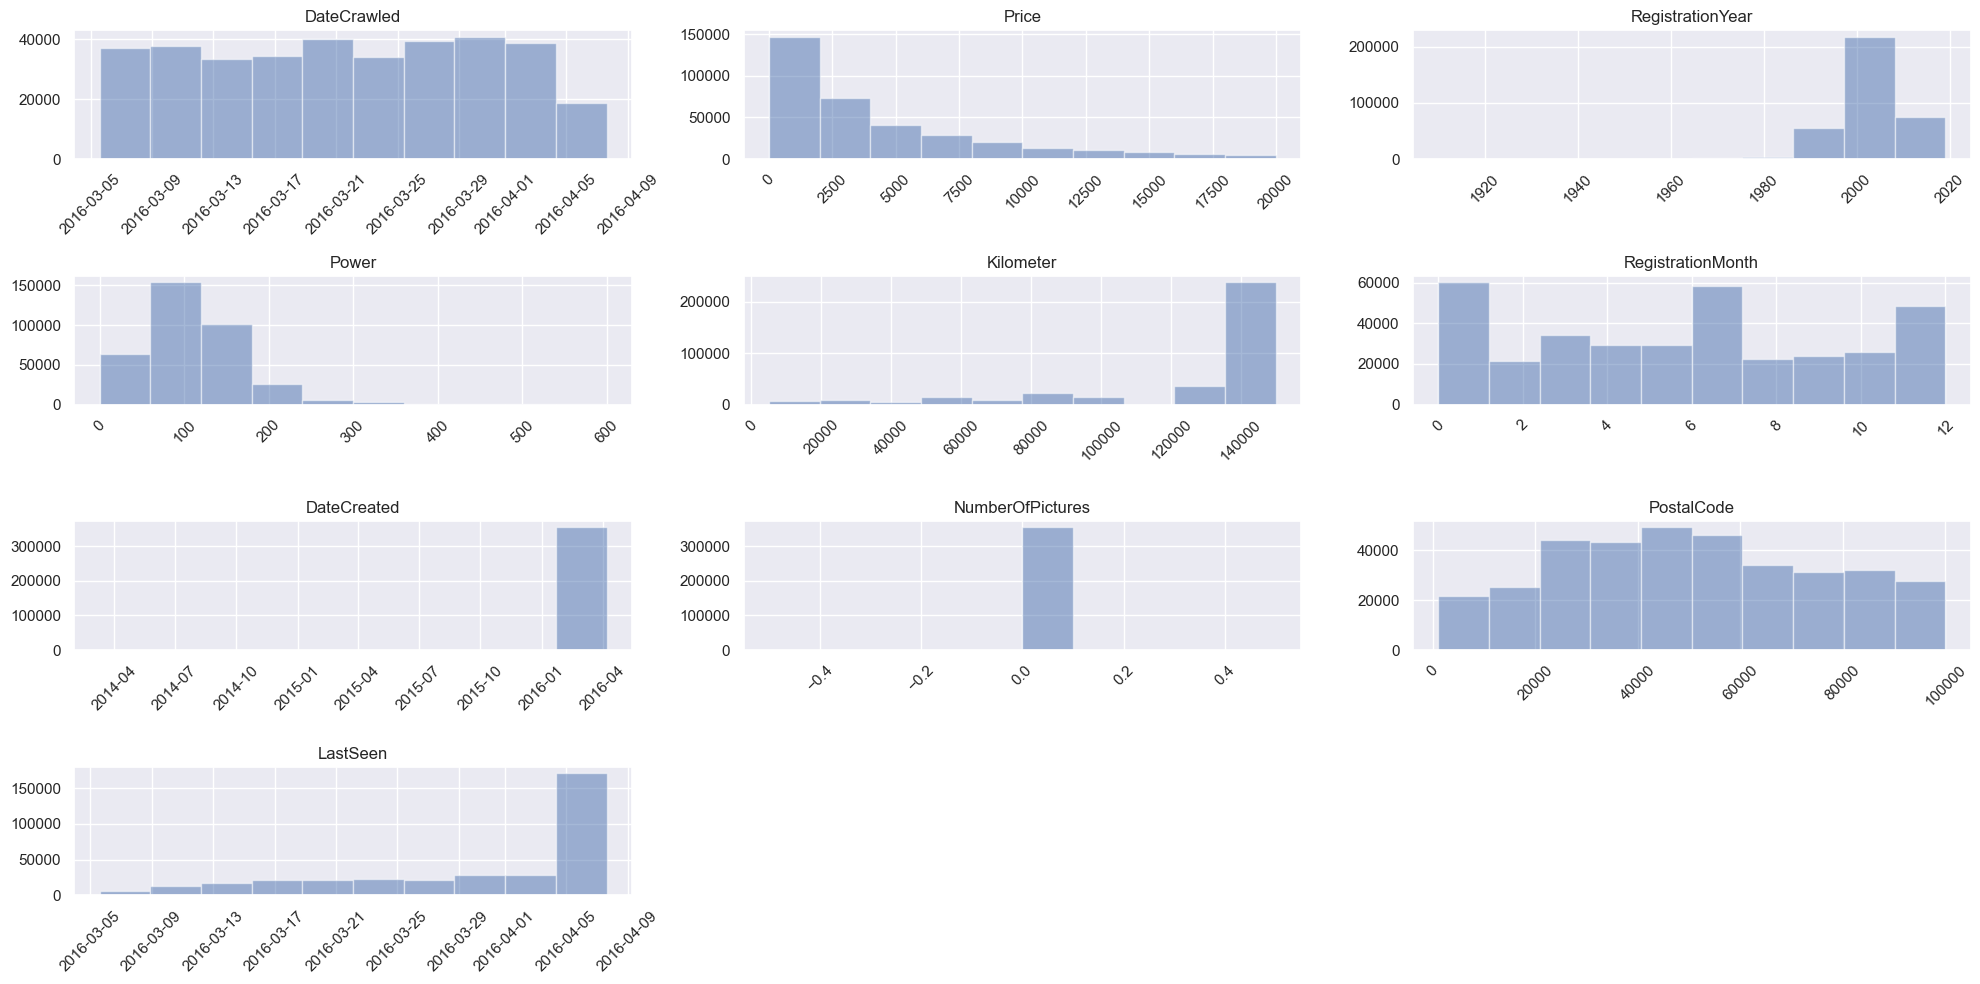

In [122]:
df.hist(alpha=0.5, figsize=(20, 10), xrot=45)
plt.tight_layout()
plt.show()


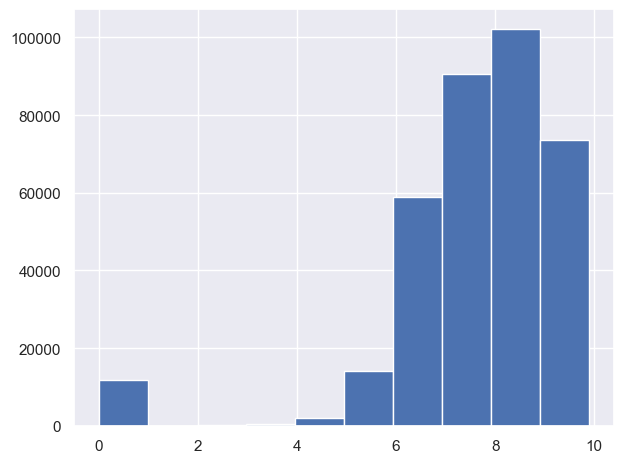

In [123]:
df["price_log"] = np.log1p(df["Price"])
df.price_log.hist()
plt.tight_layout()
plt.show()


Данные близки к нормальным, но выбивается нулевая цена. Такие объявления не несут ценности.


In [124]:
df = df.drop(columns=["price_log"]) 

#### Отбросим строки с незаполненной ценой, т.к. нередко в  объявлениях не указывают цены. Хоят товар не бесплатный.

In [125]:
df = df.loc[df.Price != 0]

## Преобразование данных в числа для дальнейшей обработки

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343412 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        343412 non-null  datetime64[ns]
 1   Price              343412 non-null  int64         
 2   VehicleType        309807 non-null  category      
 3   RegistrationYear   343412 non-null  int64         
 4   Gearbox            326173 non-null  category      
 5   Power              343412 non-null  int64         
 6   Model              325986 non-null  category      
 7   Kilometer          343412 non-null  int64         
 8   RegistrationMonth  343412 non-null  int64         
 9   FuelType           314067 non-null  category      
 10  Brand              343412 non-null  category      
 11  Repaired           277677 non-null  category      
 12  DateCreated        343412 non-null  datetime64[ns]
 13  NumberOfPictures   343412 non-null  int64        

#### Изменим тип дат на int64


In [127]:
df["DateCrawled"] = df["DateCrawled"].astype("int64")
df["DateCreated"] = df["DateCreated"].astype("int64")
df["LastSeen"] = df["LastSeen"].astype("int64")

#### Преобразуем категории в числовые значение

Создадим функцию для преобразование категории в Int

In [128]:
def category_to_dict(col: pd.Series):
    map_ = {}
    for count, category in enumerate(col.unique()):
        if pd.isna(np.array([category,])):
            continue
        map_[category] = count

    return map_

In [129]:
categories_map = {}
for category in categorical_cols:
    map_ = category_to_dict(df[category])
    categories_map[category] = map_
    df[category] = df[category].map(map_).astype("Int16")

### Поиск коррелирующих данных

<Axes: >

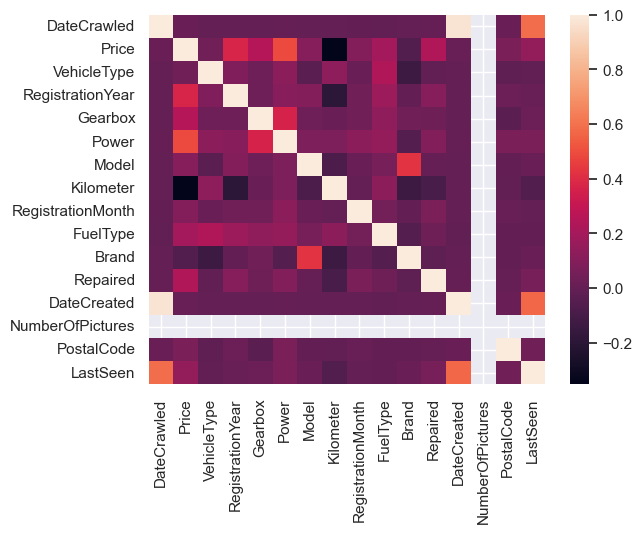

In [130]:
sns.heatmap(df.corr())

#### Видно, что DateCreated - DateCrawled имеют высокую корреляцию, NumberOfPictures - тоже можно удалить

In [131]:
df.drop(columns=["DateCrawled", "NumberOfPictures", "PostalCode"], inplace=True)

### Анализ признаков, которые имеют высокую корреляцию с ценой

In [132]:
categories_map["FuelType"]

{'petrol': 0,
 'gasoline': 1,
 'lpg': 3,
 'other': 4,
 'hybrid': 5,
 'cng': 6,
 'electric': 7}

Объедением petrol и gasoline, т.к. это одно и то же

In [133]:
df.FuelType = df.FuelType.replace(to_replace=1, value=0)

In [134]:
categories_map["Gearbox"]

{'manual': 0, 'auto': 1}

In [135]:
categories_map["Repaired"]

{'yes': 1, 'no': 2}

## Обработка пустых значение

In [136]:
df.isna().sum()

Price                    0
VehicleType          33605
RegistrationYear         0
Gearbox              17239
Power                    0
Model                17426
Kilometer                0
RegistrationMonth        0
FuelType             29345
Brand                    0
Repaired             65735
DateCreated              0
LastSeen                 0
dtype: int64

### Скалирование (портит реузльтаты, не выполняем)

In [137]:
X = df.drop('Price', axis=1)
y = df['Price']


In [99]:
# scaler = StandardScaler()
# scaler.fit(X) 

StandardScaler()

In [100]:
# X = scaler.transform(X)

In [101]:
# X = pd.DataFrame(X, index=y.index, columns=df.drop("Price", axis=1).columns)

In [94]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354147 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        316836 non-null  float64
 1   RegistrationYear   354147 non-null  float64
 2   Gearbox            334457 non-null  float64
 3   Power              354147 non-null  float64
 4   Model              334564 non-null  float64
 5   Kilometer          354147 non-null  float64
 6   RegistrationMonth  354147 non-null  float64
 7   FuelType           321393 non-null  float64
 8   Brand              354147 non-null  float64
 9   Repaired           283155 non-null  float64
 10  DateCreated        354147 non-null  float64
 11  LastSeen           354147 non-null  float64
dtypes: float64(12)
memory usage: 35.1 MB


In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED)

### 3.4 Рассмотрим признаки на основе оценки их значимости для составления математической модели:
    (Чем выше число, тем сильнее связь между признаком и целевой переменной)

In [96]:
num_features_to_select = 3
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
selector.fit(X, y)

all_feature_scores = selector.scores_
feature_names = X.columns
for feature, score in zip(feature_names, all_feature_scores):
    print(f"Признак: {feature}, Оценка: {score}")

ValueError: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [102]:

params = {'n_estimators': 500,#00,
          'max_depth': 8,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

Через cross vlaidation


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [8],
    'n_estimators': [550]
}

rf = ensemble.GradientBoostingRegressor(loss='squared_error')
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
grid_search.fit(X_cv, y_cv)

import pickle
with open("gridscv2567000", "wb") as f:
    pickle.dump(grid_search, f)

In [122]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

1550.5794061356964

In [ ]:
diff = np.subtract(np.array(y_test), grid_search.predict(X_test))

In [ ]:
diff_sort = np.sort(diff)

<Axes: ylabel='Count'>

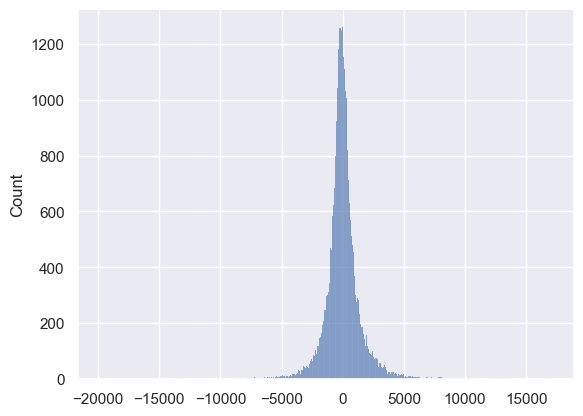

In [66]:
sns.histplot(diff_sort)

In [89]:
df['Repaired'] = df['Repaired'].fillna(3)

In [118]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DateCrawled,354187.0,1458565043743542016.0,786457653081344.5,1457186782000000000.0,1457869933500000000.0,1458582651000000000.0,1459262237000000000.0,1460039818000000000.0
Price,354187.0,4417.414403,4514.185231,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,354187.0,4.80056,2.0011,1.0,3.0,4.0,7.0,8.0
RegistrationYear,354187.0,2002.936085,13.866662,1000.0,1999.0,2003.0,2008.0,2019.0
Gearbox,354187.0,0.354313,0.750473,0.0,0.0,0.0,0.0,3.0
Power,354187.0,106.496819,63.42571,0.0,69.0,105.0,141.0,600.0
Model,354187.0,43.961949,49.112768,0.0,6.0,27.0,67.0,250.0
Kilometer,354187.0,128250.86748,37849.041257,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354187.0,5.716006,3.725769,0.0,3.0,6.0,9.0,12.0
FuelType,354187.0,0.061874,0.475861,0.0,0.0,0.0,0.0,7.0


### XGBRegressor

In [139]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [6, 8, 10],
    'n_estimators': [550, 700, 1000, 1200]
}


xgb_model = xgb.XGBRegressor(device="cuda")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

import pickle
with open("xgb", "wb") as f:
    pickle.dump(grid_search, f)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [107]:
root_mean_squared_error(y_test, grid_search.predict(X_test))

1696.7258774290842

<Axes: ylabel='Count'>

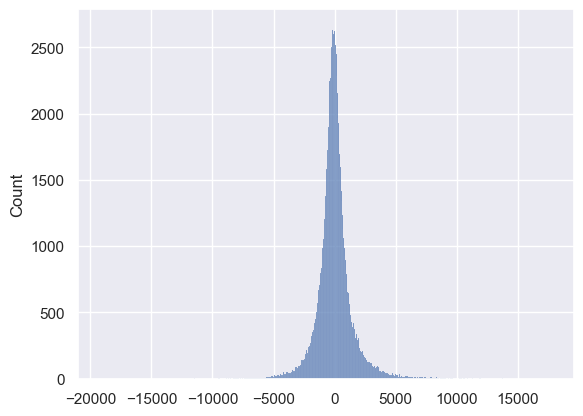

In [27]:
diff = np.subtract(np.array(y_test), xgb_model.predict(X_test))
diff_sort = np.sort(diff)
sns.histplot(diff_sort)

### LightGBM

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [6, 8, 10],
    'n_estimators': [550, 700, 1000, 1200]
}


xgb_model = lgb(device="cuda")

grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)

import pickle
with open("xgb", "wb") as f:
    pickle.dump(grid_search, f)